In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('paper')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw, rdDepictor
rdDepictor.SetPreferCoordGen(True)

AP


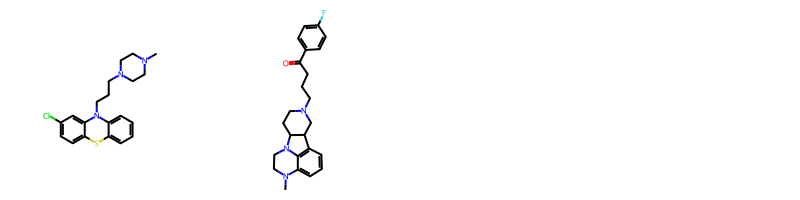

A2A


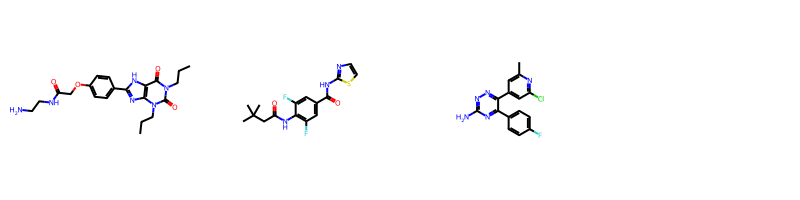

BACE1


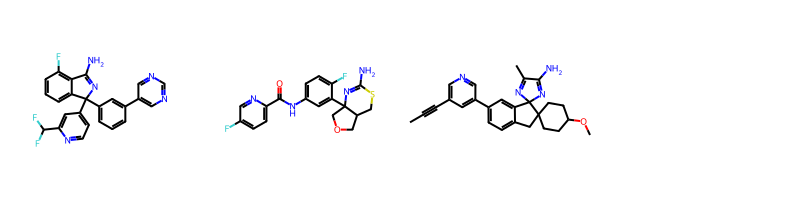

EGFR


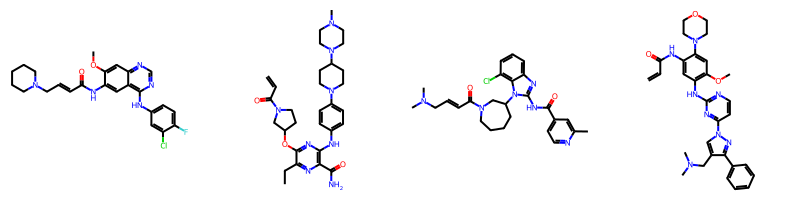

In [3]:
# Reference compounds
refs = {
    "AP": [
        'CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1',
        'CN1CCN2c3c(cccc31)C1CN(CCCC(=O)c3ccc(F)cc3)CCC12',
    ],
    "A2A": [
        'CCCN1c2c([nH]c(n2)c3ccc(cc3)OCC(=O)NCCN)C(=O)N(C1=O)CCC',
        'CC(C)(C)CC(=O)Nc1c(cc(cc1F)C(=O)Nc2nccs2)F',
        'Cc1cc(cc(n1)Cl)c2c(nc(nn2)N)c3ccc(cc3)F'
    ],
    "BACE1": [
        'NC1=NC(c2cccc(-c3cncnc3)c2)(c2ccnc(C(F)F)c2)c2cccc(F)c21',
        'NC1=NC2(c3cc(NC(=O)c4ccc(F)cn4)ccc3F)COCC2CS1',
        'CC#Cc1cncc(-c2ccc3c(c2)C2(N=C(C)C(N)=N2)C2(CCC(OC)CC2)C3)c1'
    ],

    "EGFR": [
        'COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)C=CCN1CCCCC1',
        'C=CC(=O)N1CCC(Oc2nc(Nc3ccc(N4CCC(N5CCN(C)CC5)CC4)cc3)c(C(N)=O)nc2CC)C1',
        'Cc1cc(C(=O)Nc2nc3cccc(Cl)c3n2C2CCCCN(C(=O)C=CCN(C)C)C2)ccn1',
        'C=CC(=O)Nc1cc(Nc2nccc(-n3cc(CN(C)C)c(-c4ccccc4)n3)n2)c(OC)cc1N1CCOCC1',
    ]
}

# Draw reference molecules
for k, v in refs.items():
    print(k)
    display(Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smi) for smi in v], molsPerRow=4))

# Sum stds over the replicates in the benchmark
def sum_stds(x): 
    return np.sqrt(np.sum([np.power(_, 2) for _ in x]))

## Benchmark Scores

In [4]:
# ----- Load results.csv
all_results = pd.DataFrame()
rls = [
    'SCREEN',
    'REINFORCE',
    'REINVENT',
    'REINVENT$_{MolOpt}$',
    'AHC',
    'ACEGEN$_{Practical}$',
    'ACEGEN$_{MolOpt}$',
]
dpaths = [
    'data/MolExpL_references/SCREEN_MolExpL/',
    'data/MolExpL_references/REINFORCE_MolExpL/',
    'data/MolExpL_references/REINVENT_MolExpL/',
    'data/MolExpL_references/REINVENT-MolOpt_MolExpL/',
    'data/MolExpL_references/AHC_MolExpL/',
    'data/MolExpL_references/CARL-pract_MolExpL/',
    'data/MolExpL_references/CARL-hypopt_MolExpL/',
]
for rl, dpath in tqdm(zip(rls,dpaths), desc='RL algorithm'):
    for seed, seed_path in enumerate(glob(os.path.join(dpath, '*/results.csv'))):
        result = pd.read_csv(seed_path)
        # Rename titles
        renamed_rows = []
        for i, row in result.iterrows():
            row.index = [name.replace(f" Score", "") for name in row.index]
            renamed_rows.append(row.dropna())
        result = pd.DataFrame(renamed_rows)
        # Drop model name in model parameters in results.csv
        try: result = result.drop(columns=['model_name', 'model_parameters'])
        except: pass
        # Add rl and seed
        result = result.assign(rl=rl, seed=seed)
        # Pivot
        result = result.melt(id_vars=['task', 'rl', 'seed'], var_name='metric')
        # Add
        all_results = pd.concat([all_results, result], ignore_index=True, axis=0)

# Average
avg_results = all_results.groupby(['rl', 'task', 'metric'])['value'].mean().reset_index()
std_results = all_results.groupby(['rl', 'task', 'metric'])['value'].std().reset_index()
column_order = rls

RL algorithm: 7it [00:00, 11.85it/s]


In [5]:
# ----- Print table per task
latex=False

# Pivot average
tdf = avg_results.pivot(index=['task', 'metric'], columns='rl')
tdf = tdf.droplevel(level=0, axis=1)

# Pivot std
tdf_std = std_results.pivot(index=['task', 'metric'], columns='rl')
tdf_std = tdf_std.droplevel(level=0, axis=1)

# Combine
tdf = tdf.map("{0:.2f} ".format) + u"\u00B1" + tdf_std.map(" {0:.2f}".format)
tdf

# Subset metrics 
metric_order = []
metric_order += ['Top-1 Avg (Exp)']
# Correct for multi index
n_metrics = len(metric_order)
metric_order = [(task, metric) for task in refs.keys() for metric in metric_order]
tdf = tdf.loc[metric_order, column_order]
if n_metrics == 1:
    tdf = tdf.droplevel(level="metric", axis=0)
    
# Make bold max per row
for idx, row in tdf.iterrows():
    values = [float(v.split(" ")[0]) for v in row]
    max_indices = np.argwhere(values == np.max(values)).flatten().tolist()
    for midx in max_indices:
        max_column = tdf.columns[midx]
        if latex:
            tdf.at[idx, max_column] = "\\textbf{" + tdf.at[idx, max_column] + "}"
        else:
            tdf.at[idx, max_column] = f"$\\bf{tdf.at[idx, max_column]}$"

# Print LaTeX
if latex:
    print(r"\begin{tabular}{l|" + "c"*len(rls) + "}")
    print(f" & {' & '.join([rl for rl in rls])} \\\\")
    print(r"\hline")
    for idx, row in tdf.iterrows():
        row_name = row.name.replace("&", "\&")
        print(f"{row_name} & {' & '.join([str(x) for x in row])} \\\\")
    print(r"\end{tabular}")

tdf

rl,SCREEN,REINFORCE,REINVENT,REINVENT$_{MolOpt}$,AHC,ACEGEN$_{Practical}$,ACEGEN$_{MolOpt}$
task,,,,,,,
AP,0.53 ± 0.04,0.56 ± 0.05,0.57 ± 0.04,0.63 ± 0.02,0.62 ± 0.06,$\bf0.64 ± 0.02$,$\bf0.64 ± 0.04$
A2A,0.38 ± 0.03,0.36 ± 0.02,0.39 ± 0.08,0.38 ± 0.03,0.40 ± 0.02,0.40 ± 0.07,$\bf0.44 ± 0.06$
BACE1,$\bf0.29 ± 0.08$,0.23 ± 0.02,0.21 ± 0.01,0.27 ± 0.03,0.23 ± 0.01,0.23 ± 0.03,0.28 ± 0.03
EGFR,0.17 ± 0.04,0.15 ± 0.02,0.16 ± 0.02,0.22 ± 0.03,0.17 ± 0.03,0.17 ± 0.02,$\bf0.25 ± 0.05$


In [8]:
# ----- Print table sum
latex=False

### Sum over tasks
tdf = avg_results.groupby(['rl', 'metric'])['value'].sum().reset_index()
tdf = tdf.pivot(columns='rl', index='metric')
tdf = tdf.droplevel(level=0, axis=1)

# Sum over tasks
tdf_std = std_results.groupby(['rl', 'metric'])['value'].agg(sum_stds).reset_index()
tdf_std = tdf_std.pivot(columns='rl', index='metric')
tdf_std = tdf_std.droplevel(level=0, axis=1)

tdf = tdf.map("{0:.2f} ".format) + u"\u00B1" + tdf_std.map(" {0:.2f}".format)

# Just the important metrics... 
metric_order = []
metric_order += ["Top-1 Avg (Exp)",]

tdf = tdf.loc[metric_order, column_order]

# Make bold max per row
for idx, row in tdf.iterrows():
    values = [float(v.split(" ")[0]) for v in row]
    max_indices = np.argwhere(values == np.max(values)).flatten().tolist()
    for midx in max_indices:
        max_column = tdf.columns[midx]
        if latex:
            tdf.at[idx, max_column] = "\\textbf{" + tdf.at[idx, max_column] + "}"
        else:
            tdf.at[idx, max_column] = f"$\\bf{tdf.at[idx, max_column]}$"

# Print LaTeX
if latex:
    print(f" & {' & '.join([rl for rl in rls])} \\\\")
    print(r"\hline")
    for idx, row in tdf.iterrows():
        row_name = row.name.replace("&", "\&")
        print(f"{row_name} & {' & '.join([str(x) for x in row])} \\\\")

with pd.option_context("display.precision", 2):
    display(tdf)

rl,SCREEN,REINFORCE,REINVENT,REINVENT$_{MolOpt}$,AHC,ACEGEN$_{Practical}$,ACEGEN$_{MolOpt}$
metric,,,,,,,
Top-1 Avg (Exp),1.36 ± 0.10,1.30 ± 0.06,1.33 ± 0.09,1.50 ± 0.06,1.41 ± 0.07,1.44 ± 0.08,$\bf1.62 ± 0.09$


## Training curves

In [11]:
# Load scores.csv
rls = [
    'SCREEN',
    'REINFORCE',
    'REINVENT',
    'REINVENT$_{MolOpt}$',
    'AHC',
    'ACEGEN$_{Practical}$',
    'ACEGEN$_{MolOpt}$',
]
dpaths = [
    'data/MolExpL_references/SCREEN_MolExpL/',
    'data/MolExpL_references/REINFORCE_MolExpL/',
    'data/MolExpL_references/REINVENT_MolExpL/',
    'data/MolExpL_references/REINVENT-MolOpt_MolExpL/',
    'data/MolExpL_references/AHC_MolExpL/',
    'data/MolExpL_references/CARL-pract_MolExpL/',
    'data/MolExpL_references/CARL-hypopt_MolExpL/',
]

# Load in all scores results
ref_results = pd.DataFrame()
all_files = []
for rl, dpath in zip(rls,dpaths):
    assert len(glob(os.path.join(dpath, '*'))) == 5, "5 seeds not found"
    for seed, seed_path in enumerate(glob(os.path.join(dpath, '*'))):
        score_paths = os.path.join(seed_path, '*/scores.csv')
        assert len(glob(score_paths)) == 4, "4 tasks not found"
        # Load
        for result in glob(score_paths):
            all_files.append((result, seed, rl))
ref_results = pd.concat(pd.read_csv(f, index_col=0).assign(seed=seed, rl=rl) for f, seed, rl in tqdm(all_files))

# Move absolute index to a column
ref_results.reset_index(names='idx', inplace=True)

ref_results

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 15.74it/s]


,idx,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,...,BACE1_Cmpd1_Sim,BACE1_Cmpd2_Sim,BACE1_Cmpd3_Sim,raw_BACE1_Sim,EGFR_Sim,EGFR_Cmpd1_Sim,EGFR_Cmpd2_Sim,EGFR_Cmpd3_Sim,EGFR_Cmpd4_Sim,raw_EGFR_Sim
0,0,SCREEN,A2A,1,0,3.471688,COc1ccc(C(CNC(=O)c2cc(S(=O)(=O)N3CCN(c4ccccc4)...,True,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,SCREEN,A2A,1,1,3.471688,Cn1c(N2CCCCC2)nc2c1c(=O)[nH]c(=O)n2C,True,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,SCREEN,A2A,1,2,3.471688,Cn1cc(-c2csc(NC(=O)c3cccc(Cl)c3)n2)cn1,True,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,SCREEN,A2A,1,3,3.471688,CC(C)(C)c1ccc(S(=O)(=O)N2C3CCC2CC(O)(O)C3)cc1,True,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,SCREEN,A2A,1,4,3.471688,CN(C)c1noc(-c2cccc(CNc3ccc4[nH]nc(C(N)=O)c4c3)...,True,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407984,10006,CARL,EGFR,329,23,305.842397,C=CC(=O)N1CCC(c2cnc(Nc3ccc(N4CCC(N5CCC(C)CC5)C...,True,1,False,...,NaN,NaN,NaN,NaN,0.885714,0.173077,0.885714,0.288136,0.391304,0.885714
1407985,10007,CARL,EGFR,329,24,305.842397,C=CC(=O)N1CCC(c2cnc(Nc3ccc(N4CCC(N5CCC(C)CC5)C...,True,1,False,...,NaN,NaN,NaN,NaN,0.871429,0.173077,0.871429,0.305085,0.391304,0.871429
1407986,10008,CARL,EGFR,329,25,305.842397,C=CC(=O)N1CCC(c2cnc(Nc3ccc(N4CCC(N5CCC(C)CC5)C...,True,1,False,...,NaN,NaN,NaN,NaN,0.885714,0.173077,0.885714,0.288136,0.391304,0.885714
1407987,10009,CARL,EGFR,329,26,305.842397,C=CC(=O)N1CCN(c2cnc(Nc3ccc(N4CCC(N5CCC(C)CC5)C...,True,1,False,...,NaN,NaN,NaN,NaN,0.871429,0.192308,0.871429,0.288136,0.405797,0.871429


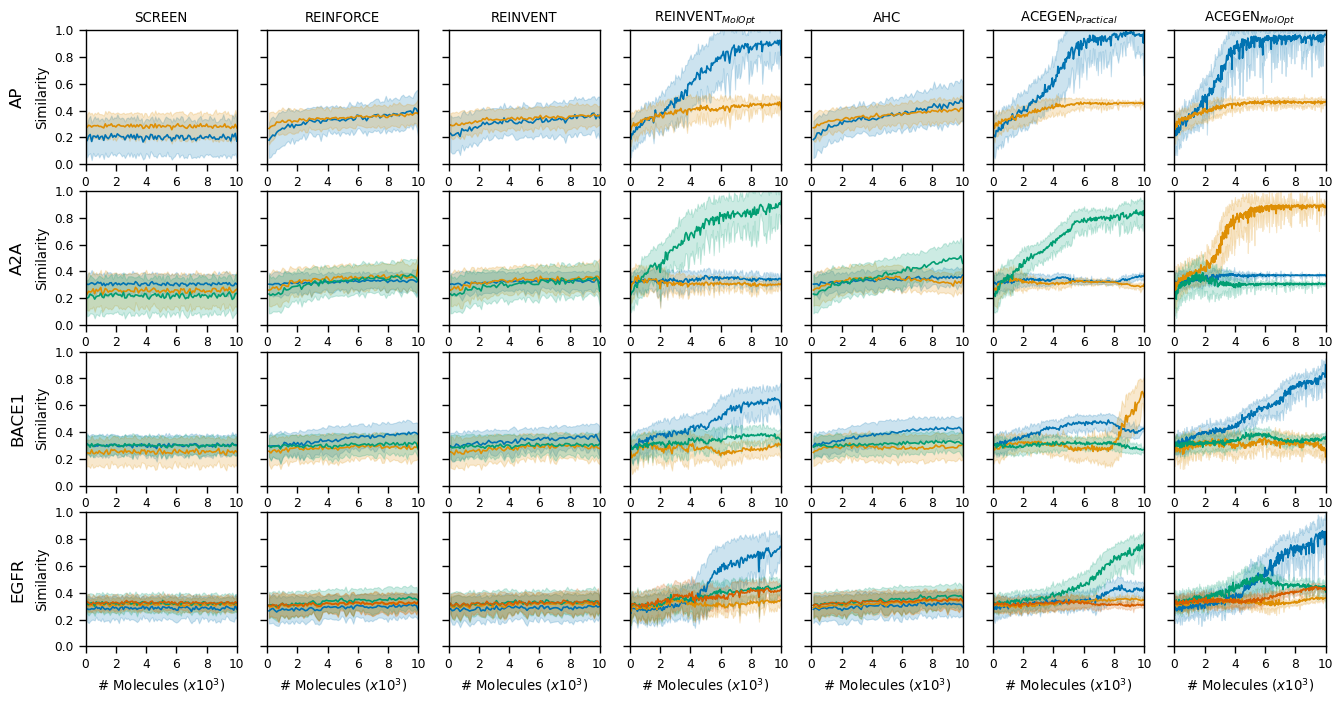

In [16]:
# ----- Plot target similariies during training 
seed = 0 # For a particular seed 0-4

fig, axes = plt.subplots(nrows=4, ncols=len(ref_results.rl.unique()), sharex=False, sharey=True, figsize=(16, 8))

for task_i, task in enumerate(refs.keys()):
    for rl_i, rl in enumerate(rls):
        # Subset data
        tdf = ref_results.loc[
          (ref_results.task==task) & 
          (ref_results.seed==seed) & 
          (ref_results.rl==rl)]
        # Subset axis
        ax = axes[task_i, rl_i]
        # Plot each similarity
        for i, _ in enumerate(refs[task]):
            sns.lineplot(
                data=tdf.loc[tdf.idx <= 10_000],
                x='step',
                y=f'{task}_Cmpd{i+1}_Sim',
                label=f'Cmpd{i+1}',
                ax=ax,
                legend=None, # To see which compound is which, comment this out.
                ci='sd'
            )
        # Label y axis
        ax.set_ylim(0, 1.0)
        ax.set_ylabel('Similarity')

        # Remap x axis from steps to # molecules
        ax.set_xticks(ticks=np.linspace(0, tdf.step.max(), 6), labels=[str(l) for l in np.linspace(0, 10, 6, dtype='int')])
        ax.set_xlim(0, tdf.step.max())
        ax.set_xlabel('# Molecules ($x10^3$)')

        # Label columns
        if task_i == 0:
            ax.set_title(rl)
            
        # Label rows
        if rl_i == 0:
            ax.text(x=-50, y=0.5, s=task, rotation='vertical', va='center', size=12)

#plt.savefig(f'figures/reference_similarity_seed{seed}.pdf', dpi=600, bbox_inches='tight')
#plt.savefig(f'figures/reference_similarity_seed{seed}.png', dpi=600, bbox_inches='tight')